In [28]:
import numpy as np
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure
from collections import defaultdict
import cv2
from functools import cmp_to_key
from scipy.ndimage import convolve
import string

CHARS = string.ascii_lowercase + string.digits + "?!.,"

# OCR - Optical Character Recognition

Spis treści:
1. [Założenia](#1-założenia)
2. [Przygotowanie danych](#2-przygotowanie-danych)
    - [Wczytanie obrazu](#wczytywanie-obrazu)
    - [Wczytywanie czcionek](#wczytywanie-czcionek)
    - [Tworzenie obrazu z tekstem](#tworzenie-obrazu-z-tekstem)
3. [Przetwarzanie obrazu](#3-przetwarzanie-obrazu)
    - [Obrót obrazu](#obrót-obrazu)
    - [Usuwanie szumu](#usuwanie-szumu)
    - [Dodanie wszystkich znaków](#dodanie-wszystkich-znaków-do-obrazu)
4. [Wyszukiwanie znaków](#4-wyszukiwanie-znaków)
    - [Korelacja](#korelacja)
    - [Zaznaaczanie znalezionych znaków](#zaznaczanie-znalezionych-znaków)
    - [Kolejność wykrywania znaków](#kolejność-wykrywania-znaków)
    - [Wykrywanie znaków](#wykrywanie-znaków)
5. [Postprocessing](#5-postprocessing)
    - [Podział na linie](#podział-na-linie)
    - [Podział na słowa](#podział-na-słowa)
6. [OCR](#6-ocr)
    - [Implementacja](#implementacja)
    - [Testowanie](#testowanie)
7. [Rezultaty](#7-rezultaty)
   - [Czcionka bezszeryfowa](#czcionka-bezszeryfowa-sans-serif)
   - [Czcionka szeryfowa](#czcionka-szeryfowa-times-new-roman)
   - [Obrazy obrócone](#obrazy-obrócone)
   - [Obrazy zaszumione](#obrazy-zaszumione)
8. [Podsumowanie](#8-podsumowanie)

# 1. Założenia

- Tekst składa się z małych liter alfabetu łacińskiego oraz cyfr.
- Na obrazie występuje jeden typ i rozmiar czcionki.
- Występują znaki przestankowe:   .  ,  !  ?
- Tekst składa się z wielu linii.
- Tekst może być obrócony.
- Program pownien zwracać tekst wraz ze znakami białymi i znakami nowej linii.
- Program powinien zliczać liczbę wystąpień każdego znaku.

# 2. Przygotowanie danych

## Wczytywanie obrazu

Obraz wczytuję za pomocą biblioteki `PIL` i konwertuję go na skalę szarości

In [2]:
def load_image(filepath, invert=True):
    if invert:
        return ImageOps.invert(Image.open(filepath).convert('L'))
    return Image.open(filepath).convert('L')

## Wczytywanie czcionek

Do mojego programu przygotowałem dwa zestawy czcionek (pliki w formacie `.ttf`):
- szeryfową (`times new roman`)
- nie szeryfową (`sans-serif`)  

In [6]:
def load_fonts(fontname, fontsize):
    return ImageFont.truetype(f'fonts/{fontname}.ttf', fontsize)

## Tworzenie obrazu z tekstem

Do utworzenia obrazu z tekstem używam biblioteki `PIL`. Tworzę obraz o wymiarach `1000x1000` pikseli, a następnie dodaję na nim tekst.  
Przy ewentualnych argumentach obraz może być obrócony o dany kąt i/lub nałożony na niego szum.

In [4]:
def draw_text(text, font_name, font_size, rotate=0, noise=0, inverted=False):
    def add_noise(img, noise):
        img = np.array(img)
        noise = np.random.normal(0, noise, img.shape)
        noisy = img + noise
        noisy = np.clip(noisy, 0, 255)
        return Image.fromarray(noisy.astype(np.uint8))
    font = load_fonts(font_name, font_size)
    length = int((max([font.getlength(line) for line in text.split('\n')])+10)*1.1)
    img = Image.new('L', (length, 1000), color='black')
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), text, font=font, fill='white')
    cropped = img.crop(img.getbbox())
    rotated = cropped.rotate(rotate, expand=1)
    reversed = ImageOps.invert(rotated)
    padded = ImageOps.expand(reversed, border=1, fill='white')
    noised = add_noise(padded, noise)
    if inverted:
        return ImageOps.invert(noised)
    return noised

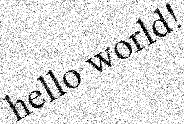

In [5]:
display(draw_text("hello world!", 'times-new-roman', font_size=40, rotate=30, noise=60, inverted=False))

# 3. Przetwarzanie obrazu

## Obrót obrazu

Wykrywam najmniejszy prostokąt, który zawiera tekst i obracam go tak, aby był prostokątem o bokach równoległych do osi układu współrzędnych:
- jeśli jest skierowany w górę to ustawiam kąt na przeciwny
- jeśli jest skierowany w dół to ustawiam kąt na dopełnienie 90 stopni

In [6]:
def rotate_image(img):
    img_inv = np.array(ImageOps.invert(img.copy()))
    coords = np.column_stack(np.where(img_inv > 0))
    p1, p2, angle = cv2.minAreaRect(coords)

    if p1[1] < p2[1]:
        angle = -angle
    else:
        angle = 90 - angle
    return img.rotate(angle, expand=1, fillcolor=255, resample=Image.BICUBIC)

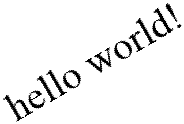

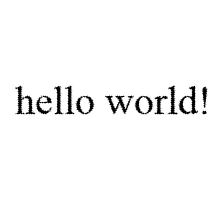

In [7]:
img = draw_text("hello world!", 'times-new-roman', font_size=40, rotate=30)
display(img)
display(rotate_image(img))

## Usuwanie szumu

Do usuwania szumu wykorzystuję dwie metody w zależności od argumentu `lib`:
- średnie lokalne - interpolacja dwuwymiarowa, dla każdego piksela obliczam średnią z jego sąsiadów z otoczenia o rozmiarze 3x3 o poniżych współczynnikach.  
- średnie globalne - aby osiągnąć lepsze wynik wykorzystuję funkcję z biblioteki `cv2` opartą o algorytm [`NLM`](https://www.ipol.im/pub/art/2011/bcm_nlm/)

In [8]:
def remove_noise(image, lib=True):
    img = np.array(image)
    if lib:
        return Image.fromarray(cv2.fastNlMeansDenoising(img, None, 40, 7, 21))
    kernel = np.array([[0.5, 2, 0.5], [2, 0.5, 2], [0.5, 2, 0.5]], dtype=np.float64)
    kernel /= kernel.sum()
    smooth_data = convolve(img, kernel)
    return Image.fromarray(smooth_data.astype(np.uint8))

In [23]:
img = draw_text("hello world!", 'times-new-roman', font_size=40, noise=60)
display(img)
display(remove_noise(img))

## Dodanie wszystkich znaków do obrazu 

Aby mieć pewność, że znak został rozpoznany, dodaję do obrazu wszystkie wzorce znaków z wybranego zestawu czcionek, które będą porównywane z obrazem wejściowym. Dzięki temu dodane wzorce powinny mieć największe wartości korelacji, właśnie z tą wartością będę porównywał obraz wejściowy.

In [8]:
def add_char_patterns(image, font, fontsize, text=CHARS):
    patterns = draw_text(text, font, fontsize, noise=0, inverted=True)
    result = Image.new('L', (max(image.width, patterns.width), image.height + patterns.height), 0)
    result.paste(image, (0, 0))
    result.paste(patterns, (0, image.height))
    return np.array(result)

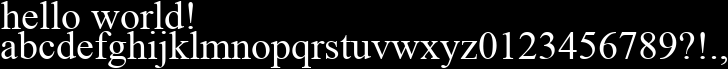

In [10]:
img = draw_text("hello world!", 'times-new-roman', font_size=40, inverted=True)
added = add_char_patterns(img, 'times-new-roman', 40)
display(Image.fromarray(added))

# 4. Wyszukiwanie znaków

## Korelacja

In [13]:
def correlation(image, sample):
    return np.real(ifft2(np.multiply(fft2(np.array(image)), fft2(np.rot90(sample, 2), np.array(image).shape))))

## Zaznaczanie znalezionych znaków

In [11]:
def highlight_matches(image, pattern, char, matches, ratio=10):
    fig, ax = plt.subplots(figsize=(image.shape[0]//ratio, image.shape[1]//ratio))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{char} - {len(matches)} found')
    for x, y in matches:
        ax.add_patch(patches.Rectangle((y, x), -pattern.shape[1], -pattern.shape[0], edgecolor='r', facecolor='none'))
    plt.show()

## Kolejność wykrywania znaków

Kolejność wykrywania znaków ustalam na podstawie odwrotnej listy liczby wykrytych znaków w obrazie zawierającym wszystkie znaki - skoro z daną pewnością wykryłem pewien znak więcej niż jeden raz to jest większa szansa na pomylenie go w obrazie wejściowym.

Głównym powodem takiego stanu jest podobieństwo niektórych znaków, np. 'i' i 'l', oraz zawieranie się niektórych znaków w innych, np. 'c' w 'e'.

In [20]:
def correlation_heatmap(font, font_size, show=False):
    heatmap = np.zeros((len(CHARS), len(CHARS)))
    for i, char1 in enumerate(CHARS):
        for j, char2 in enumerate(CHARS):
            background = draw_text(char1, font, font_size, inverted=True)
            sample = draw_text(char2, font, font_size, inverted=True)
            img = add_char_patterns(background, font, font_size, char2)
            img_corr = correlation(img, sample)
            heatmap[i, j] = img_corr[:background.height, :background.width].max() / img_corr.max()
    
    if show:
        plt.figure(figsize=(7, 7))
        plt.yticks(range(len(CHARS)), CHARS)
        plt.xticks(range(len(CHARS)), CHARS)
        plt.title('Correlation between characters')
        plt.colorbar(plt.imshow(heatmap, cmap='hot'))
        plt.show()

    return heatmap

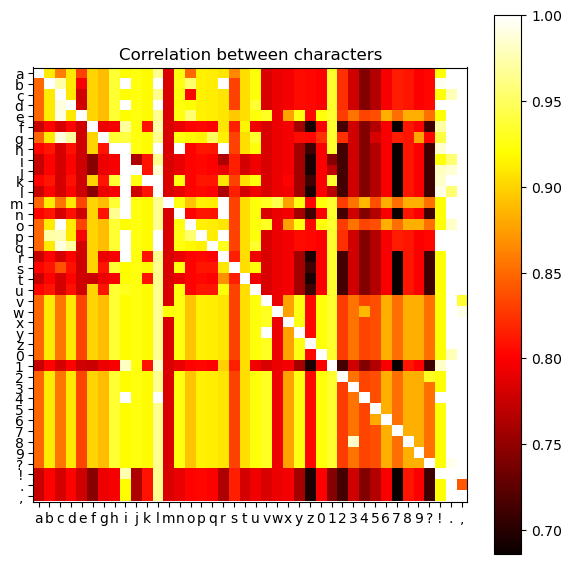

In [35]:
_ = correlation_heatmap('sans-serif', font_size=40, show=True)

In [55]:
def get_char_order(font, font_size, confidence=0.99, ratio=5, show=False, default=True):
    if default:
        return ['a', 'h', 'd', 'e', 'f', 'g', 'b', 'j', 'k', 'm', 
                'p', 'q', 's', 't', 'o', 'n', 'w', 'x', 'y', 'z',
                '0', '1', '2', '4', '6', '5', '7', '8', '9', 'u',
                'r', 'v', '3', 'l', 'i', 'c', '?', '!', '.', ',']
    
    counter_dict = defaultdict(list)
    background = np.array(draw_text(CHARS, font, font_size=font_size, inverted=True))

    for char in CHARS:
        sample = np.array(draw_text(char, font, font_size=font_size, inverted=True))
        img_cor = correlation(background, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        count = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
        counter_dict[count].append(char)
    
        if show:
            _, ax = plt.subplots(figsize=(background.shape[0]//ratio, background.shape[1]//ratio))
            ax.set_title(f'{char} - {count} found')
            ax.imshow(background, cmap='gray')
            for i, j in np.argwhere(img_cor!=0.):
                ax.add_patch(patches.Rectangle((j,i), -sample.shape[1], -sample.shape[0], edgecolor='r', facecolor='none'))
            plt.show()
    
    probabilities = correlation_heatmap(font, font_size, show=False)
    order = []
    for bucket in sorted(counter_dict.keys()):
        order += sorted(counter_dict[bucket], 
                        key=cmp_to_key(lambda y, x: probabilities[CHARS.index(x), CHARS.index(y)] - probabilities[CHARS.index(y), CHARS.index(x)]))

    return order

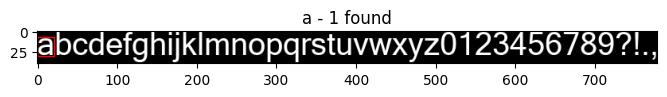

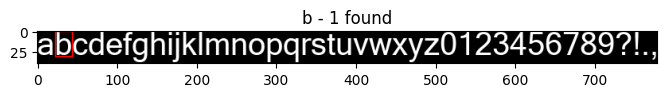

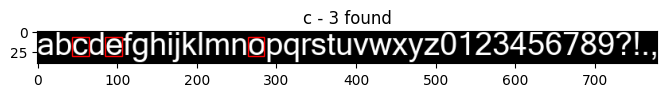

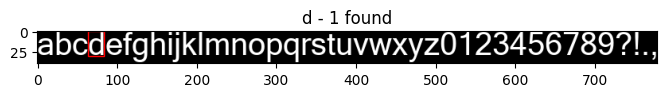

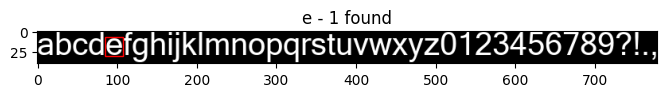

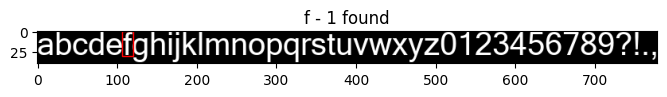

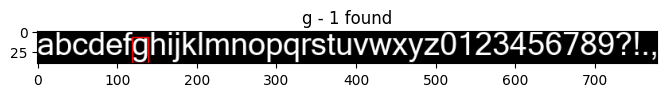

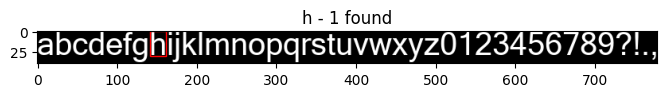

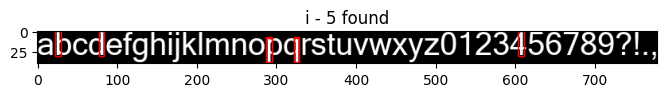

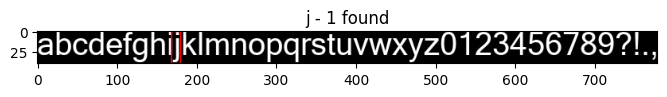

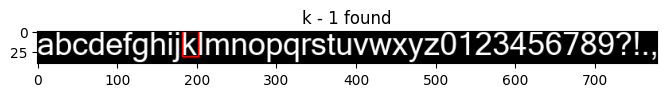

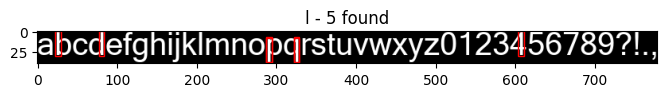

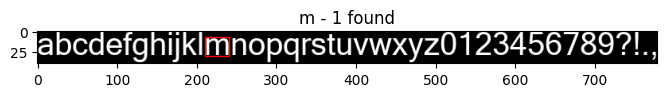

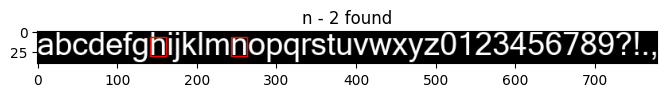

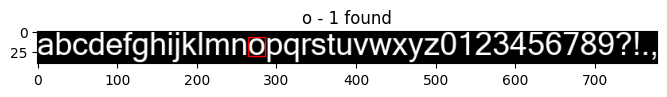

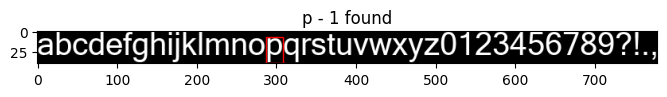

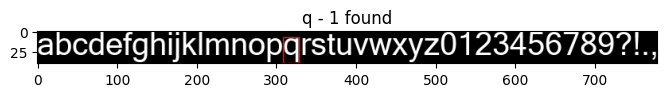

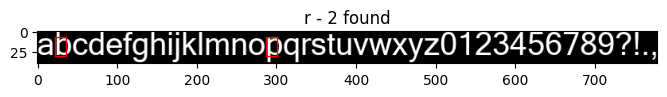

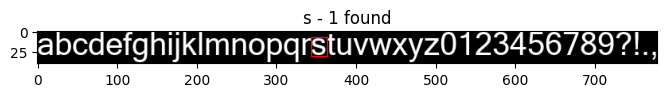

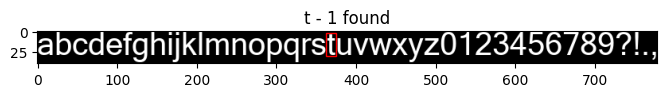

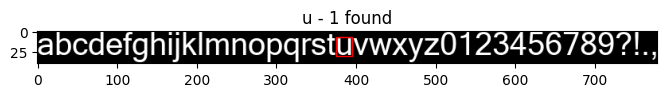

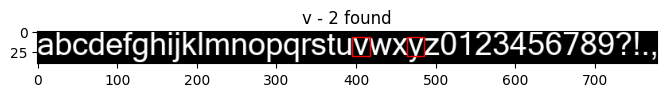

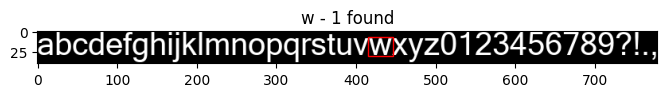

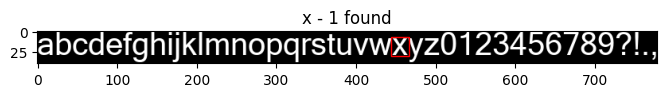

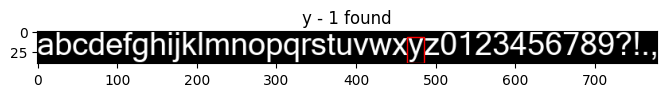

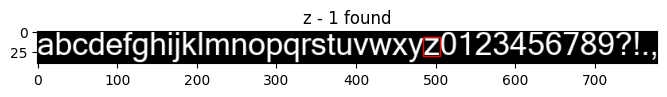

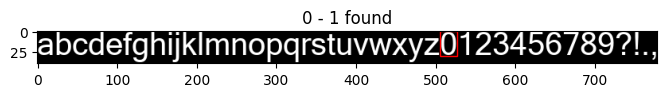

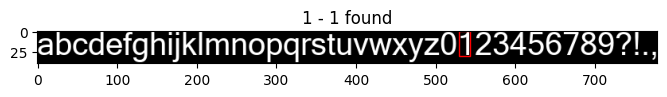

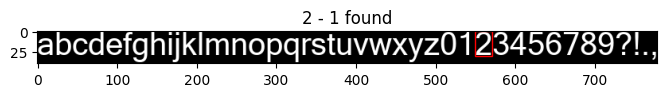

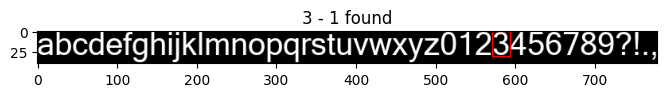

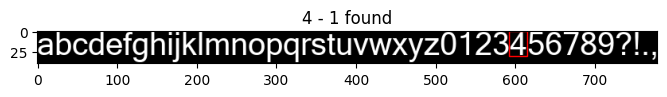

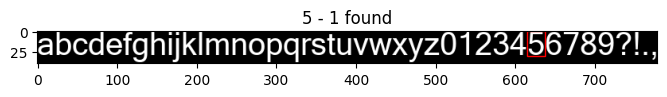

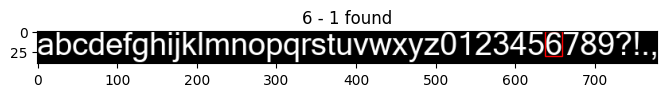

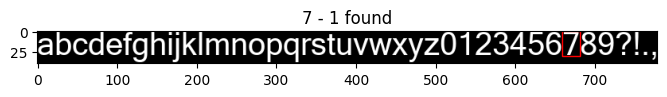

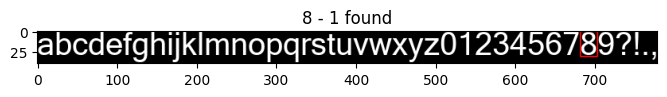

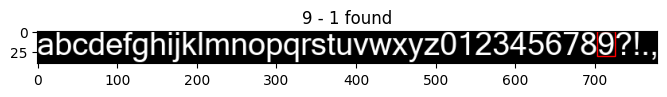

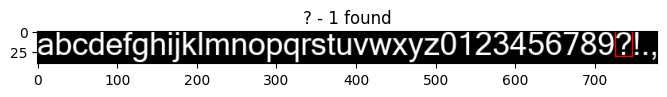

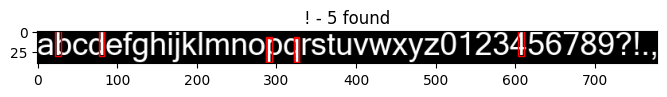

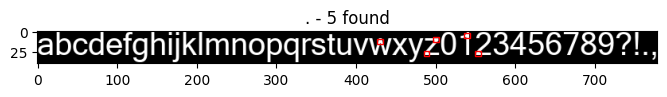

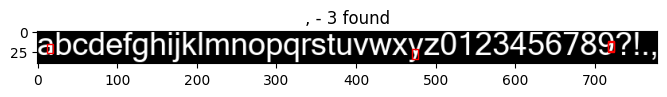

['m',
 'w',
 'z',
 '2',
 '4',
 'e',
 '5',
 '7',
 '?',
 '3',
 'x',
 '8',
 '9',
 '6',
 '0',
 'y',
 'a',
 'g',
 'd',
 'p',
 'b',
 'q',
 'o',
 's',
 'k',
 'u',
 'h',
 'f',
 't',
 '1',
 'j',
 'v',
 'n',
 'r',
 'c',
 ',',
 'l',
 '!',
 'i',
 '.']

In [56]:
get_char_order('sans-serif', font_size=40, show=True, default=False)

## Wykrywanie znaków

In [ ]:
def read_text(image, font, fontsize, confidence, show=False):
    char_order = get_char_order(font, show)
    enchanced = add_char_patterns(image, font, fontsize)
    positions = []
    for char in char_order:
        if char in ['.']:
            confidence = 0.95
        sample = np.array(draw_text(char, font, fontsize, inverted=True))
        img_cor = correlation(enchanced, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        if show:
            highlight_matches(enchanced, sample, char, np.argwhere(img_cor!=0.))
        for i, j in np.argwhere(img_cor!=0.):
            for x in range(1, sample.shape[0]):
                for y in range(1, sample.shape[1]):
                    enchanced[i-x, j-y] = 0
            positions.append((i, j, char))

    return positions       

# 5. Postprocessing

## Podział na linie

In [ ]:
def line_division(positions, font, fontsize):
    lines = defaultdict(list)
    lineheight = draw_text('a', font, fontsize).height
    for y, x, char in positions:
        for line in lines.keys():
            if abs(y - line) < lineheight:
                lines[line].append((x, char))
                break
        else:
            lines[y] = [(x, char)]
    
    return [line for _, line in sorted(lines.items())][:-1]

## Podział na słowa

In [ ]:
def word_division(lines, font, fontsize):
    text = ""
    space = load_fonts(font, fontsize).getlength(' ') * 0.7
    for line in lines:
        prev_x = min(line)[0]
        for i, (x, char) in enumerate(sorted(line)):
            if i > 0 and x - prev_x - draw_text(char, font, fontsize).width >= space:
                text += ' '
            text += char
            prev_x = x
        text += '\n'
        
    return text

# 6. OCR

## Implementacja

In [ ]:
def ocr(image, font, fsize=40, confidence=0, isnoised=False, isrotated=False, show=False):
    if isnoised: image = remove_noise(image)
    if isrotated: image = rotate_image(image)
    image = ImageOps.invert(image)
    ready = image.crop(image.getbbox())
    positions = read_text(ready, font, fsize, confidence=confidence, show=show)
    lines = line_division(positions, font, fsize)
    text = word_division(lines, font, fsize)
    return text, {c: text.count(c) for c in CHARS}

## Testowanie

Do przetestowania poprawności działania programu wykorzystałem kryterium dystansu Levenshteina.  
[wikipedia/levenstein_distance](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [ ]:
def levenshtein_distance(expected, result):
    matrix = np.zeros((len(result)+1, len(expected)+1))
    for i in range(1, len(result)+1):
        for j in range(1, len(expected)+1):
            sub_cost = 0 if result[i-1] == expected[j-1] else 1
            matrix[i, j] = min(matrix[i-1, j] + 1, 
                               matrix[i, j-1] + 1, 
                               matrix[i-1, j-1] + sub_cost)
    return (len(expected)-matrix[-1, -1]) / len(expected) * 100

In [ ]:
def test(expected, font, fontsize, confidence, noise=0, rotate=0, show_print=False, show_ocr=False):
    image = draw_text(expected, font, fontsize, noise=noise, rotate=rotate)
    result, _ = ocr(image, font, fontsize, confidence, isnoised=noise>0, isrotated=rotate!=0, show=show_ocr)
    percentage = levenshtein_distance(expected, result[:-1])
    if show_print: 
        display(image)
        print(f"""Expected:\n{expected}\n
                  Result:  \n{result})\n
                  Levenshtein result: {percentage}%""")
    return percentage

# 7. Rezultaty

In [ ]:
sizes = [20, 40, 60]
text = "butelka jest czarna, a gdzie slonce?\n" \
       "to jest pytanie na ktore nie znam odpowiedzi\n" \
       "wiec nie pytaj mnie o to.\n" 

### Czcionka bezszeryfowa (sans-serif)

In [ ]:
font = 'sans-serif'
for size, conf in zip(sizes, [0.99, 0.99, 0.99]):
    test(text, font, size, conf, show_print=True, show_ocr=True)

### Czcionka szeryfowa (times new roman)

In [ ]:
font = 'times-new-roman'
for size, conf in zip(sizes, [0.99, 0.99, 0.99]):
    test(text, font, size, conf, show_print=True, show_ocr=True)

### Obrazy obrócone

In [ ]:
test(text, 'sans-serif', 40, noise=0, rotate=20, confidence=0.93)
test(text, 'times-new-roman', 40, noise=0, rotate=20, confidence=0.92)

### Obrazy zaszumione

In [ ]:
test(text, 'sans-serif', 40, noise=30, confidence=0.84)
test(text, 'times-new-roman', 40, noise=30, confidence=0.8)

# 8. Podsumowanie

Widać, że program działa poprawnie. Ale większych czcionek (>=30) lepiej sobie radzi z czcionkami bezszeryfowymi, a mniejszych z szeryfowymi.
MORE O WYNIKACH szeyfa

TODO O ROTACJI

TODO O SZUMIE

OGOLNE WRAZENIA

---

TODO
- ZAKOMENTOWANY KOD W USUWANIU OBROTU
```
    # gray = np.array(img)
    # gray = cv2.bitwise_not(gray)
    # thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # coords = np.column_stack(np.where(thresh > 0))
```
- PODSUMOWANIE DOKOŃCZYĆ